<a href="https://colab.research.google.com/github/liadmagen/NLP-Course/blob/master/exercises_notebooks/10_LM_Transformers_full.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformers using HuggingFace

Transformers is a Machine Learning architecture that uses self-attention mechanism to improve the classification.

## Setup

In [43]:
%%capture
!pip install transformers
!pip install datasets

In [28]:
from pprint import pprint

# BERT

## Introduction
BERT was first released in 2019, and made a revolution in the NLP world.
It was shortly after several similar models such as ELMo and UlmFit demonstrated that using contextual word-embedding significantly improve the model accuracy.

Contextual word-embedding are vectors that are changed according to the usage of the word in the sentence. Unlike the previous embedding techniques - Word2Vec, GloVe, FastText, etc, ELMo, UlmFit and BERT change the word-embedding of the same word, according to its usage.

So for example, the word `play` would have different vectors in these sentences:
* I *play* tennis on Thursday
* I saw that *play* already

BERT uses Transformers to create a matrix of relations between the words in the sentence. It is memory expensive, and therefore **cannot take more than two sentences at once**, and up to 512 tokens in total.

### Dive Deeper

To learn more about BERT, HuggingFace had released a great introduction: [BERT 101 🤗 State Of The Art NLP Model Explained](https://huggingface.co/blog/bert-101). In this tutorial, they explain what is BERT, how is it used, it's impact on both the language model and NLP, as well as the environment.

Also recommended to go over their notebooks: [A Visual Notebook to Using BERT for the First Time](https://colab.research.google.com/github/jalammar/jalammar.github.io/blob/master/notebooks/bert/A_Visual_Notebook_to_Using_BERT_for_the_First_Time.ipynb)

### BERT Family 

However, since then, many new and more efficient models were released:
- [BigBird](https://huggingface.co/blog/big-bird#bigbird-block-sparse-attention), [Longformer](https://huggingface.co/allenai/longformer-base-4096), [Reformer](https://huggingface.co/google/reformer-crime-and-punishment) and many others, can handle classification of long documents.
- [RoBERTa](https://huggingface.co/roberta-base) and [Electra](https://huggingface.co/google/electra-small-discriminator) are memory and GPU efficient, and can train faster
- Models such as [LayoutLM](https://huggingface.co/microsoft/layoutlmv2-base-uncased) can handle a combination of both text and image, and are useful in classification of visually rich documents such as invoices, IDs and Forms.


Before diving into BERT's family, let's start with the original BERT structure.

#### SideNote: Language Models
[Lilian Weng](https://www.linkedin.com/in/lilianweng/) is a leading NLP researcher and her [BLOG](https://lilianweng.github.io/lil-log/) is a great source to stay up to date with the field.

Specificaly, she wrote a very extensive post about language models, such as [BERT, T5, Electra, etc., and the differences between them. Worth reading!](https://lilianweng.github.io/lil-log/2019/01/31/generalized-language-models.html#supervised-fine-tuning)

## Full Model Example

In [25]:
import torch
import pandas as pd

from transformers import BertTokenizer, BertModel, BertForMaskedLM


In [26]:
import logging
logging.basicConfig(level=logging.INFO)

Remind yourself of the discussion about BERT in the class. BERT has several predefined tokens. Specifically, '[CLS]' begins a sequence, and '[SEP]' separates between sentences.

The token '[MASK]' is used to teach the model to predict the missing words during training. 

BERT needs three (3) sequences as an input:
1. The sentence words - tokenized and converted to a list of IDs
2. Segment IDS - 0s and 1s indicating which words belong to which sentence, and
3. A position encoding vector

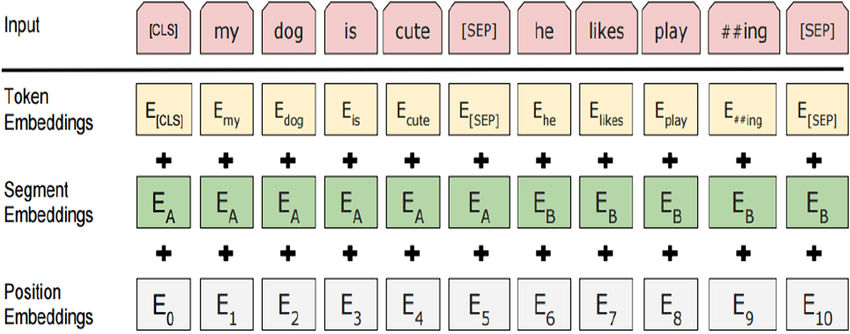

In [29]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize input
text = "[CLS] Who was Jim Henson ? [SEP] Jim Henson was a puppeteer [SEP]"
tokenized_text = tokenizer.tokenize(text)

# Mask a token that we will try to predict back with `BertForMaskedLM`
masked_index = 8
tokenized_text[masked_index] = '[MASK]'
assert tokenized_text == ['[CLS]', 'who', 'was', 'jim', 'henson', '?', '[SEP]', 'jim', '[MASK]', 'was', 'a', 'puppet', '##eer', '[SEP]']

# Convert token to vocabulary indices
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
# Define sentence A and B indices associated to 1st and 2nd sentences (see paper)
segments_ids = [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]

# Convert inputs to PyTorch tensors
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])


In [30]:
tokenized_text

['[CLS]',
 'who',
 'was',
 'jim',
 'henson',
 '?',
 '[SEP]',
 'jim',
 '[MASK]',
 'was',
 'a',
 'puppet',
 '##eer',
 '[SEP]']

HuggngFace supplies many already trained models (pretrained models) suitable for different tasks. These models were trained in various languages and diverse activities. Some are specialized for specific tasks such as sentiment analysis, question answering, etc. Some, however, are more 'general' or 'global' and can be used for different tasks.

We will use here the original BERT - which is not used in the industry but only for research purposes.

For 'real-world' predictions, it is recommended to use the RoBERTa model (see the next section - named RoBERTa).

To illustrate the usage of Huggingface's models, we show here two examples - one with the original BERT (BertModel) and one with Bert for Masked Language Models - BertMaskLM:

In [18]:
# Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-uncased')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Set the model in evaluation mode to deactivate the DropOut modules
# This is IMPORTANT to have reproducible results during evaluation!
model.eval()

# If you have a GPU, put everything on cuda
tokens_tensor = tokens_tensor.to(device)
segments_tensors = segments_tensors.to(device)
model.to(device)

# Predict hidden states features for each layer
with torch.no_grad():
    # See the models docstrings for the detail of the inputs
    outputs = model(tokens_tensor, token_type_ids=segments_tensors)
    
    # Transformers models always output tuples.
    # See the models docstrings for the detail of all the outputs
    # In our case, the first element is the hidden state of the last layer of the Bert model
    encoded_layers = outputs[0]

# We have encoded our input sequence in a FloatTensor of shape (batch size, sequence length, model hidden dimension)
assert tuple(encoded_layers.shape) == (1, len(indexed_tokens), model.config.hidden_size)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [19]:
# Load pre-trained model (weights)
model = BertForMaskedLM.from_pretrained('bert-base-uncased')
model.eval()

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# If you have a GPU, put everything on cuda
tokens_tensor = tokens_tensor.to(device)
segments_tensors = segments_tensors.to(device)
model.to(device)

# Predict all tokens
with torch.no_grad():
    outputs = model(tokens_tensor, token_type_ids=segments_tensors)
    predictions = outputs[0]

# confirm we were able to predict 'henson'
predicted_index = torch.argmax(predictions[0, masked_index]).item()
predicted_token = tokenizer.convert_ids_to_tokens([predicted_index])[0]
assert predicted_token == 'henson'

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


As the warning demonstrates, these models can not be used 'out-of-the-box' and must be trained further before we can use them for making predictions.

## Fine-tune example.

Let's fine-tune BERT on our beloved domain: **Pizza and Ice Cream**.

We will train a sentiment analysis on the topic - where 1 is positive, and 0 is a negative sentiment.


In [20]:
from transformers import BertForSequenceClassification
from torch.optim import AdamW

In [21]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', 
                                                      num_labels = 2,
                                                      return_dict=True)
model.train()

optimizer = AdamW(model.parameters(), lr=1e-5)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

As you can see from the warning message, the weights we loaded into the model - `bert-base-uncased` were trained on some corpus, but were never trained on our specific task. So it's up to us to fine-tune it on that given task.

This is also called training on a down-stream task.

### Fine-Tuning vs Training
We don't want to train the WHOLE Bert. 

It took more than four days with the help of hundreds of GPUs to train it on a massive amount of textual data. Instead, we would like to fine-tune only the upper layers to match our needs.

The optimizer lets us choose layers where we want to focus at:

In [22]:
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=1e-5)


Let's prepare our "training data":

In [23]:
text_batch = ["I love Ice Cream.", 
         "I don't care for Ice Cream.", 
         "I like my pizza cold", 
         "The pizza was cold", 
         "The ice cream was amazing", 
         "The pizza toppings wer boring",
         "He would like fries with that",
         "Ice cream is awesome"]
  
labels = [1, 
          0,
          1,
          0,
          1,
          0,
          1,
          1]

Tokenizing and encoding can be done through the huggingFace library using either:

In [24]:
encoding = tokenizer(text_batch, 
                     return_tensors='pt', # pt = pyTorch 
                     padding=True, 
                     truncation=True)

input_ids = encoding['input_ids']
attention_mask = encoding['attention_mask']

print(input_ids[0])
print(attention_mask[0])

tensor([ 101, 1045, 2293, 3256, 6949, 1012,  102,    0,    0,    0,    0])
tensor([1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0])


or (newer):

In [25]:
encoded_dict = tokenizer.encode_plus(
                        text_batch,                # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        padding = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                        truncation=True
                   )
pprint(encoded_dict)

{'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]),
 'input_ids': tensor([[101, 100, 100, 100, 100, 100, 100, 100, 100, 102]]),
 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])}


In [26]:
text_batch

['I love Ice Cream.',
 "I don't care for Ice Cream.",
 'I like my pizza cold',
 'The pizza was cold',
 'The ice cream was amazing',
 'The pizza toppings wer boring',
 'He would like fries with that',
 'Ice cream is awesome']

In [32]:
# Tokenizing the sentences is performing several actions.
# this is NOT the way to do it - and only brought here for the same of explaining:
small_train_dataset = []

# For every sentence...
for sent in text_batch:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        padding = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                        truncation=False
                   )
    
    # Add the encoded sentence to the training list.
    small_train_dataset.append(encoded_dict)

A better way to perform it, is using either `pandas` or huggingface's `dataset`. 

In [ ]:
df = pd.DataFrame({"labels": labels, "text": text_batch})

The HuggingFace library is constantly changing. The best method is to keep an eye on their excellent tutorials to know what the best 'current' way to run it.

For example, [this fine-tuning tutorial](https://huggingface.co/docs/transformers/training) will guide you how to use BERT family using the HuggingFace trainer, with TensorFlow's Keras or directly in native pyTorch.

In the next section - RoBERTa - we will do the same thing, but with the RoBERTa instead of the original BERT model. 


In [ ]:
### Try it your self - train a model on some toy dataset to your choice ###
### Follow the tutorial: https://huggingface.co/docs/transformers/training



# Roberta


Instead of the big and combersome BERT, try using the smart sister: [roBERTa - A Robustly Optimized BERT Pretraining Approach](https://github.com/pytorch/fairseq/tree/master/examples/roberta)

**RoBERTa** (short for Robustly optimized BERT approach; [Liu, et al. 2019](https://arxiv.org/abs/1907.11692)) refers to a new receipt for training BERT to achieve better results, as they found that the original BERT model is significantly undertrained. The receipt contains the following learnings:

Train for longer with a bigger batch size.
Remove the next sentence prediction (NSP) task.
Use longer sequences in training data format. The paper found that using individual sentences as inputs hurts downstream performance. Instead, we should use multiple sentences sampled contiguously to form longer segments.
Change the masking pattern dynamically. The original BERT applies masking once during the data preprocessing stage, resulting in a static mask across training epochs. RoBERTa applies masks in 10 different ways across 40 epochs.
RoBERTa also added a new dataset CommonCrawl News and further confirmed that pretraining with more data helps improve the performance on downstream tasks. It was trained with the BPE on byte sequences, same as in GPT-2. They also found that choices of hyperparameters have a major impact on the model performance.


HuggingFace fully supports it - https://huggingface.co/transformers/model_doc/roberta.html - but a few adjustments are necessary to get it to work.

Check out the tutorial section for info on how to use their impressive framework:
* https://huggingface.co/transformers/pretrained_models.html



Due to its availability and efficiency, RoBERTa is quite common in text classification, and we will use it here to classify patents, using the [patents dataset](https://huggingface.co/datasets/ccdv/patent-classification) that is hosted in [HuggingFace Dataset Hub](https://huggingface.co/datasets).

We will use [HuggingFace](https://huggingface.co/) implementation of RoBERTa. HuggingFace is a french company that has lately took over the field, due to their excellent engineering efforts, open-source software and a very large community who contributed both models, datasets and code.

Huggingface offers also [NLP courses](https://huggingface.co/course/chapter1/1), where they guide the users how to use their software.

In [64]:
%%capture
!pip install transformers
!pip install datasets

In [65]:
import numpy as np

from datasets import load_dataset, load_metric
from transformers import RobertaTokenizer, RobertaForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding


### Datasets
[Datasets](https://huggingface.co/docs/datasets/) is a library and a hub by HuggingFace that helps procesing datasets.

The hub contains a large variety of pre-made datasets for different tasks and in many different languages.

The Datasets library itself contains tool to process the data and to divide it to Train / Validation / Test sets. 

We will use here a pre-made dataset for **Patent-Classification**.

In [66]:
dataset = load_dataset('ccdv/patent-classification')


Downloading:   0%|          | 0.00/3.93k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/487M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/99.4M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/97.9M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset patent_classification_dataset downloaded and prepared to /root/.cache/huggingface/datasets/ccdv___patent_classification_dataset/patent/1.0.0/296a870cf0b6aa21c8cbd74f4fcd0dafdf4d7795cc2bba5ee2918ddd85225740. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

The dataset is already divided to Train, Validation and Test.

In [67]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 5000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 5000
    })
})

In [68]:
# Let's peek at one of the examples (always look at your data!)
dataset['train'][0]

{'label': 6,
 'text': 'turning now to the drawings , there is shown in fig1 an integrated circuit continuity testing system in which a specimen or circuit configuration 16 is mounted on a fixture 18 operable to vibrate the specimen under controlled conditions , e . g . sinusoidally , randomly , or a combination of the two . the specific structure of the fixture and the means for vibrating it are known in the art and thus not further discussed . the specimen and fixture are housed in a closed chamber 20 whereby the specimen under test can be subjected to temperature cycling , either alone or in conjunction with the vibration testing . an environmental control apparatus , indicated at 22 , is provided for selectively heating or cooling the chamber interior . a cable 24 electrically connects fixture 18 , and thus specimen 16 , with a continuity testing board 26 . it is to be understood that cable 24 includes a multiplicity of separate electrical connections between fixture 18 and testing 

In [69]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

https://huggingface.co/roberta-base/resolve/main/vocab.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpvyv7rzxg


Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

storing https://huggingface.co/roberta-base/resolve/main/vocab.json in cache at /root/.cache/huggingface/transformers/d3ccdbfeb9aaa747ef20432d4976c32ee3fa69663b379deb253ccfce2bb1fdc5.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
creating metadata file for /root/.cache/huggingface/transformers/d3ccdbfeb9aaa747ef20432d4976c32ee3fa69663b379deb253ccfce2bb1fdc5.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
https://huggingface.co/roberta-base/resolve/main/merges.txt not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpw4nmxt72


Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

storing https://huggingface.co/roberta-base/resolve/main/merges.txt in cache at /root/.cache/huggingface/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
creating metadata file for /root/.cache/huggingface/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/roberta-base/resolve/main/vocab.json from cache at /root/.cache/huggingface/transformers/d3ccdbfeb9aaa747ef20432d4976c32ee3fa69663b379deb253ccfce2bb1fdc5.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
loading file https://huggingface.co/roberta-base/resolve/main/merges.txt from cache at /root/.cache/huggingface/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/roberta-bas

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

storing https://huggingface.co/roberta-base/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
creating metadata file for /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hid

We use RoBERTa's tokenizer, to tokenize our dataset's text.

Remember - we can't use the text as it is, we must tokenize and process it first into units that the model expects.

For pre-processing the data there are two options. We can either: 
* create an encoded copy of the dataset, or
* create a transformation function that encode it with the tokenizer, on the fly: https://huggingface.co/docs/datasets/process.html?highlight=map#format-transform

In [ ]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)


## Warning: Processing large amounts of data is a heavy task and may take
# relatively long to finish.
encoded_dataset = dataset.map(preprocess_function, batched=True)

  0%|          | 0/25 [00:00<?, ?ba/s]

We instantiate a RoBERTa model for classification of sentences or sequences of words in general. It was already pre-trained on wikipedia and other text resources. 

In [ ]:
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=dataset['train'].features['label'].num_classes)

Then we *fine-tune* our RoBERTa model on our dataset.

Fine-tuning is an additional training that keeps most of the model weights intact, but does make some updates to the weights to match it to the task in hand.

In [ ]:
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

training_args = TrainingArguments(
    output_dir='./results',
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=5,
    weight_decay=0.01,
    evaluation_strategy="epoch",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()


And we call the `evaluate()` method, which uses the dataset's **Test** part.

In [ ]:
trainer.evaluate()

For more information, please check these notebooks in HuggingFace:
* Fine-tuning a pretrained model: https://github.com/huggingface/notebooks/blob/master/transformers_doc/training.ipynb
* Fine-tuning a model on a text classification task: https://github.com/huggingface/notebooks/blob/master/examples/text_classification.ipynb

And more good resources can be found here: https://huggingface.co/docs/transformers/notebooks

## Try it yourself

This part is optional - but recommended. It will give you the experience in the real world usage of BERT based classification models.

Try training a classifier yourself, using RoBERTa or any of the other models that huggingface offers.

HuggingFace have a [special guide](https://huggingface.co/docs/transformers/training) to fine tune a pre-trained classifier. 

The basic code for classification of a sequence (e.g. a sentence) is using their `SequenceClassification`:

```
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2)
```



Here are several ideas you can choose from: 

## Sentence Acceptability

1. classify an acceptability of a sentence, https://arxiv.org/abs/1805.12471

For example:
* Good - What did Betsy paint a picture of?
* Bad - What was a picture of painted by Betsy?

The dataset can be downloaded from:
https://nyu-mll.github.io/CoLA/

And the corresponding kaggle competition:

https://www.kaggle.com/c/cola-out-of-domain-open-evaluation

## Toxic Comments Classification
2. Toxic comments classification

https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data

Classify which of the comments are toxic, by fine-tuning RoBERTa on the dataset.

# Sentiment Analysis Example

We will use a great package from [hugging-face](https://huggingface.co/) called `Transformers`

In [ ]:
from transformers import pipeline

They have already trained and made ready some pipelines, using BERT for tasks such as sentiment-analysis classification:

In [ ]:
nlp = pipeline('sentiment-analysis')

In [ ]:
nlp('we love you')

But be aware that although it may seem to be working well ...

In [ ]:
nlp('I ate pizza with olives.')

In [ ]:
nlp('I ate pizza with olives. it was cold')

In [ ]:
nlp('I ate pizza with olives, but the pizza was cold')

... it might not always match your expectations:

In [ ]:
nlp('It was cold outside. I ate pizza with olives.')

In [ ]:
nlp('I am dying to see you')

Let's test the pipeline of filling-in masked values (cloze style), which is one of the ways the model was actually trained with:

In [ ]:
nlp = pipeline("fill-mask")

In [ ]:
pprint(nlp(f"There's no place like {nlp.tokenizer.mask_token}."))

However, don't expect the model to be able to answer questions. It captured only the information it was trained on:

In [ ]:
pprint(nlp(f"{nlp.tokenizer.mask_token} is the president of the united states."))

# SentenceTransformers

Another important package that is worth knowing is the [SentenceTransformers](https://www.sbert.net/).

This package makes the embedding of a sentence easier, and allows also searching in the corpus for the most similar sentences. It is often used in real world applications, and recommended in general.